# Strategies

In trading, the strategies to enter and exit the market (buy or sell a symbol) are usually different.
- We enter a market because we have some certainty of the evolution of the price.
- We exit a market if the actual evolution of the price is different to the one initially predicted.

Both types of strategies are continuously processing new candlesticks and when the strategy conditions are met, they get triggered and generate a trading request. Notice this request can be accepted or not by the main system, according to the current state of the system. 

Therefore, we have 2 different classes for strategies, *EntryStrategy* and *ExitStrategy*. They both inherit from the *Strategy* class which contains the common attributes:
- name: The name of the strategy which will serve as id.
- params: A dictionary with the parameters needed to compute the strategy's time series.
- input_series_names: A list with the names of the time series to be computed in the strategy.
- portfolio: A *Portfolio* object from where to get the candlestick data to compute the strategy.
- queue: A *PriorityQueue* where the requests generated by the estrategy are placed.
- requests_counter: A counter used to generate unique names for the requests of the strategy.

A part from these common attributes, the *Strategy* class has a set of methods that need to be overriden by the child classes that inherent them.
- compute_input_series(): It computes the set of time series (basic time series, indicators...) and returns them.
- compute_trigger_series(): It computes the trading triggers of the strategy in a series.
- compute_requests_queue(): It computes the actual requests objects from the triggers and puts them in the internal queue.

## Entry Strategy

The Entry strategy also has an extra method
- create_exit_strategy(self, trade: Trade)

This allows for the shit.

### Import libraries and set up portfolio

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
%matplotlib qt

import sys
sys.path.insert(0, "..")  # Adds higher directory to python modules path.

from traphing.data_classes import Velas, Portfolio
from traphing.strategies import Trade
from traphing.strategies.entry import EntryStrategy, CrossingMovingAverages

from traphing.utils import Timeframes, unwrap
import traphing.utils  as ul

from traphing.graph.Gl import gl

folder_images = "./images/python_generated/strategies/"

In [2]:
symbol_names_list = ["AUDCHF"]
timeframes_list = [Timeframes.M15]
portfolio_name = "my_portfolio"

storage_folder = "../tests/data/storage/"

portfolio = Portfolio(portfolio_name, symbol_names_list, timeframes_list)
portfolio.load_data_from_csv(storage_folder)

start_time = dt.datetime(2019,7,20); end_time = dt.datetime(2019,7,25)
portfolio.set_time_interval(start_time,end_time)

Size ../tests/data/storage/M15/AUDCHF_M15.csv:  100400  rows


## Crossing Moving Averages Entry Strategy

As an Example of how entry strategies work, we are going to see Crossing Moving averages in action

In [3]:
## TODO: find a way to do this automatically
if(0):
    with open("../traphing/strategies/entry/common/CrossingMovingAverages.py", "r") as readme_file:
        readme = readme_file.read()
    print(readme)

In [4]:
class CrossingMovingAverages(EntryStrategy):
    """Strategy: Given a fast and a slow Moving Average, fast_MA and slow_MA respectively:
        - If the fast_MA cross the slow_MA upwards: BUY trigger
        - If the fast_MA cross the slow_MA downwards: SELL trigger
    The slow_MA represents the baseline price and fast_MA the trend.
    
    params Example:
        slow_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args": {"n":45}}
        fast_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args":{"n":20}}
    """
    def __init__(self, name: str, portfolio: Portfolio = None, params: dict = {}):
        super().__init__(name, portfolio, params)
        self.input_series_names = ["slow_MA", "fast_MA"]
    
    """
    ############ Overriding parent methods ###########################
    """
    def compute_input_series(self):
        slow_MA_params = self.params["slow_MA"]
        fast_MA_params = self.params["fast_MA"]
        slow_MA = self.portfolio.velas_indicator(**slow_MA_params)
        fast_MA = self.portfolio.velas_indicator(**fast_MA_params)
        series_df = pd.concat([slow_MA,fast_MA],axis = 1, keys = self.input_series_names)
        return series_df
    

    def compute_trigger_series(self):
        series_df = self.compute_input_series()
        trigger_series = ul.check_crossing(series_df["slow_MA"], series_df["fast_MA"])
        return trigger_series
        
    
    def compute_requests_queue(self):
        trigger_series = self.compute_trigger_series()
        Event_indx = np.where(trigger_series != 0)[0] # We do not care about the second dimension
        
        for indx in Event_indx:
            action = self._get_action(trigger_series[indx])
            timestamp = trigger_series.index[indx]
            symbol_name = self.params["slow_MA"]["symbol_name"]
            timeframe = self.params["slow_MA"]["timeframe"]
            price = float(self.portfolio[symbol_name][timeframe].get_candlestick(timestamp)["Close"])
            
            self.create_request(timestamp, symbol_name, price, action)

        return self.queue
    
    def create_exit_strategy(self, trade: Trade):
        exit_strategy = StopLoss(name = "StopLoss_for_" + trade.name, trade = trade, portfolio = self.portfolio)
        
        symbol_name = trade.request.symbol_name
        timeframe = self.portfolio[trade.request.symbol_name].timeframes_list[0]
        exit_strategy.params["Close"] = {"symbol_name":symbol_name, "timeframe":timeframe}
        exit_strategy.set_stop_loss(pct = 0.3)
        return exit_strategy

### Instanciating the object

The only mandatory argument is the id, used to reference the signals created by the strategy.

In [5]:
entry_strategy = CrossingMovingAverages("CMA", portfolio)
print (entry_strategy.input_series_names)

['slow_MA', 'fast_MA']


### Setting the strategy parameters

In this case, the parameters of the strategy, are the parameters needed to compute the fast and slow moving averages

No signal is computed, this information will allow the system to compute it in the future.

In [14]:
symbol_name = symbol_names_list[0]
timeframe = timeframes_list[0]

# Set the paramters
slow_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args": {"n":30}}
fast_MA_params = {"symbol_name":symbol_name,"timeframe": timeframe,"indicator_name":"SMA", "args":{"n":10}}
entry_strategy.set_params({"fast_MA": fast_MA_params, "slow_MA": slow_MA_params})

print (entry_strategy.params)

{'fast_MA': {'symbol_name': 'AUDCHF', 'timeframe': <Timeframes.M15: 15>, 'indicator_name': 'SMA', 'args': {'n': 10}}, 'slow_MA': {'symbol_name': 'AUDCHF', 'timeframe': <Timeframes.M15: 15>, 'indicator_name': 'SMA', 'args': {'n': 30}}}


## Computing the series

Once we have the portfolio and parameters of the strategy load, we can compute:
- input series: The series that are computed using the portfolio and the parameters.
- trigger series: 

In [15]:
entry_strategy_series = entry_strategy.compute_input_series()
entry_strategy_series

,fast_MA,slow_MA
Timestamp,,
2019-07-22 00:00:00,NaN,NaN
2019-07-22 00:15:00,NaN,NaN
2019-07-22 00:30:00,NaN,NaN
2019-07-22 00:45:00,NaN,NaN
2019-07-22 01:00:00,NaN,NaN
...,...,...
2019-07-25 22:45:00,0.688327,0.688511
2019-07-25 23:00:00,0.688282,0.688544
2019-07-25 23:15:00,0.688280,0.688607


In [16]:
entry_series = entry_strategy.compute_trigger_series()
entry_series

Timestamp
2019-07-22 00:00:00    0.0
2019-07-22 00:15:00    0.0
2019-07-22 00:30:00    0.0
2019-07-22 00:45:00    0.0
2019-07-22 01:00:00    0.0
                      ... 
2019-07-25 22:45:00    0.0
2019-07-25 23:00:00    0.0
2019-07-25 23:15:00    0.0
2019-07-25 23:30:00    0.0
2019-07-25 23:45:00    0.0
Name: Crosses, Length: 384, dtype: float64

## Computing the entry requests

In [17]:
entry_requests_queue = entry_strategy.compute_requests_queue()
entry_requests_queue.get()

(Timestamp('2019-07-22 09:15:00'),
 <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bc63bd90>)

In [18]:
n_requests = entry_requests_queue.qsize()
entry_requests_dict = dict([entry_requests_queue.get() for i in range(n_requests)])
entries_dates = sorted(list(entry_requests_dict.keys()))
entry_request = entry_requests_dict[entries_dates[0]]
unwrap(entry_request)

<EntryTradeRequest>	object has children:
    <str>	name:	CMA#6
    <str>	strategy_name:	CMA
    <Timestamp>	timestamp:	2019-07-22 15:00:00
    <str>	symbol_name:	AUDCHF
    <Actions>	action
    <float>	price:	0.6915899999999999
    <datetime>	queue_timestamp:	2019-10-23 15:51:24.467805
    <int>	priority:	0
    <str>	comments:	

  <Actions>	action has children:
      <int>	_value_:	-1
      <str>	_name_:	SELL
      <str>	_name_:	SELL




In [19]:
entry_requests_dict

{Timestamp('2019-07-22 15:00:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd2621d0>,
 Timestamp('2019-07-22 17:45:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd1828d0>,
 Timestamp('2019-07-23 00:30:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd1823d0>,
 Timestamp('2019-07-23 00:45:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd182f50>,
 Timestamp('2019-07-23 01:00:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd182d10>,
 Timestamp('2019-07-23 01:30:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd182710>,
 Timestamp('2019-07-23 02:15:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd182b10>,
 Timestamp('2019-07-23 08:45:00'): <traphing.strategies.entry._core_classes.EntryTradeRequest at 0x7fa6bd182e10>,
 Timestamp('2019-07-23 11:15:00'): <traphing.strategies.entry._core_classes.EntryTradeRe

## Unwrapping the object

In [20]:
unwrap(entry_strategy)

<CrossingMovingAverages>	object has children:
    <str>	name:	CMA
    <dict>	params
    <Portfolio>	portfolio
    <int>	requests_counter:	25
    <PriorityQueue>	queue
    <list>	input_series_names

  <list>	input_series_names has children:
      <str>	input_series_names[0]:	fast_MA
      <str>	input_series_names[1]:	slow_MA

  <PriorityQueue>	queue has children:
      <int>	maxsize:	0
      <list>	queue
      <lock>	mutex
      <Condition>	not_empty
      <Condition>	not_full
      <Condition>	all_tasks_done
      <int>	unfinished_tasks:	25

    <Condition>	all_tasks_done has children:
        <lock>	_lock
        <lock>	_lock
        <lock>	_lock
        <deque>	_waiters

      <deque>	_waiters has children:

      <lock>	_lock has children:

      <lock>	_lock has children:

      <lock>	_lock has children:

    <Condition>	not_full has children:
        <lock>	_lock
        <lock>	_lock
        <lock>	_lock
        <deque>	_waiters

      <deque>	_waiters has children:

      <lock>

## Plotting

One of the main advantages of separating the strategy's logic in input_series, triggers and entry requests is that we can automatically access the strategy data and plot it.


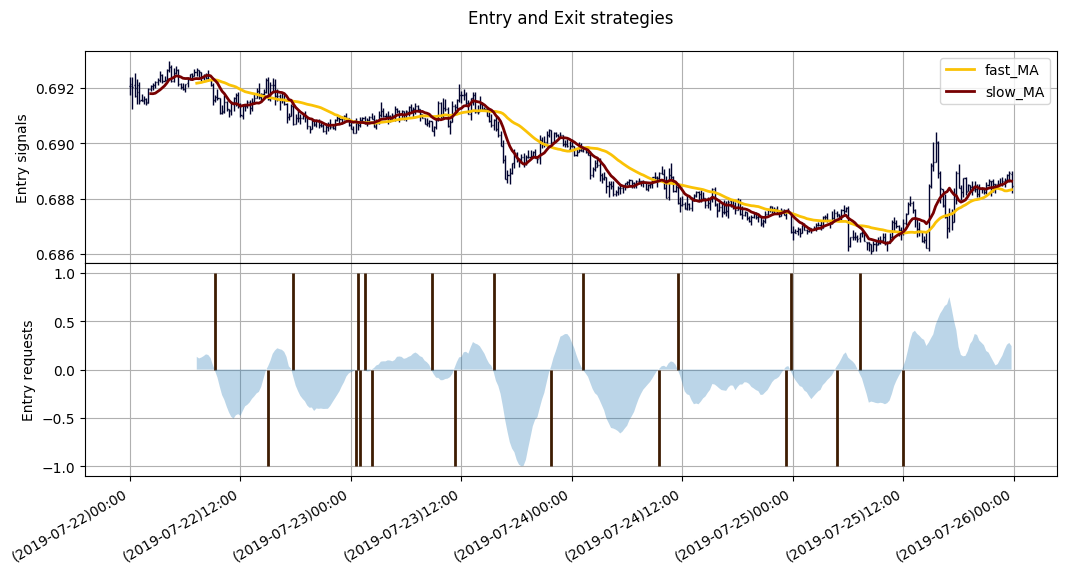

In [21]:
image_name = "entry_strategy.png"; img_path = folder_images + image_name
gl.init_figure()
n_rows, n_cols = 2,1; size_inches = [12, 5]

ax1 = gl.subplot2grid((n_rows, n_cols),(0,0))
ax2 = gl.subplot2grid((n_rows, n_cols),(1,0), sharex = ax1)

portfolio[symbol_name][timeframe].plot_barchart(axes = ax1, labels = ["Entry and Exit strategies", "", "Entry signals"])
gl.plot(entry_strategy_series.index, entry_strategy_series, legend = list(entry_strategy_series.columns), axes =ax1)

difference = entry_strategy_series["slow_MA"] - entry_strategy_series["fast_MA"]
normalized_difference = difference/np.max(np.abs((difference)))
gl.fill_between(entry_strategy_series.index, normalized_difference, 
                labels = ["", "", "Entry requests"], legend = "Normalized signal diff", axes =ax2, alpha = 0.3)
gl.stem(entry_strategy_series.index,entry_series, axes = ax2, legend = "Trades")

gl.subplots_adjust(left=.09, bottom=.10, right=.90, top=.95, wspace=.20, hspace=0, hide_xaxis = True)
gl.save_figure(img_path, dpi = 100, size_inches = size_inches, close = True)
Image(img_path)